# <font color=#219ebc>Recommandation de films - Modelisation </font>

# Sommaire
* [Configuration](#Configuration)
* [Chargement des données](#Chargement-des-donnees)
* [Filtrage sur le contenu](#Filtrage-sur-le-contenu)
    * [Similarités](#Similarites)
    * [Similarités genres](#Similarites-genres)
    * [Similarités plots](#Similarites-plots)
* [Algorithme de filtrage](#Algorithme-de-filtrage)
* [Tests](#Tests)
* [Moteur](#Moteur)    


## <font color=#fb8500>Configuration</font>

In [1]:
import matplotlib as mplt

import seaborn as sns
sns.set(font='Franklin Gothic Book',rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})

# use the .set_context() method to fine-tune font size settings.
#sns.set_context("notebook", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":14})

mplt.font_manager._rebuild()

## <font color=#fb8500>Chargement des donnees</font>

In [2]:
import time
start=time.time()

In [3]:
import pandas as pd

dfGenres=pd.read_csv("./movie_genres.csv",sep=",",encoding="utf-8")
dfPlots=pd.read_csv("./movie_plots.csv",sep=",",encoding="utf-8")
dfMovies=pd.read_csv("./movie_metadata_clean.csv",sep=",",encoding="utf-8")

## <font color=#fb8500>Filtrage sur le contenu</font>

Les moteurs de recommandation de contenu n'ont pas besoin de notes de l'utilisateur.\
Calculons à quel point chaque film est proche ou éloigné l'un de l'autre, en fonction des variables.

### <font color=#ffb703>Similarites</font>

#### Similarite cosinus

Soit A le vecteur film, B le vecteur genre

$\displaystyle sim(A,B)=cos(θ)=\frac{A.B}{\|A\| \|B\|}$

Sur la base de la valeur du cosinus, qui varie entre -1 et 1, les films sont classés par ordre décroissant

In [4]:
import numpy as np

def similariteCosinus(A, B):
    AB=A.T.dot(B)
    ANorm=np.linalg.norm(A)
    BNorm=np.linalg.norm(B)
    
    #result=np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B))
    result = AB/(ANorm * BNorm)
    return result

In [5]:
# calcul de similarité Cosinus entre 2 films (par genre)
A = np.array(dfGenres.iloc[1])
B = np.array(dfGenres.iloc[2])
similariteCosinus(A,B)

0.6666666666666667

In [6]:
def matriceSimilariteCosinus(A,B):
    num=np.dot(A,B.T)
    p1=np.array(np.sqrt(np.sum(A**2,axis=1)))[:,np.newaxis]
    p2=np.array(np.sqrt(np.sum(B**2,axis=1)))[np.newaxis,:]
    return num/(p1*p2)

### <font color=#ffb703>Similarites genres</font>

In [7]:
# calcul de similarité entre l'ensemble des 4000 films suivant leurs genres
mGenres=matriceSimilariteCosinus(dfGenres,dfGenres)
print(mGenres)

[[1.         0.8660254  0.57735027 ... 0.         0.         0.        ]
 [0.8660254  1.         0.66666667 ... 0.         0.         0.        ]
 [0.57735027 0.66666667 1.         ... 0.33333333 0.         0.        ]
 ...
 [0.         0.         0.33333333 ... 1.         0.33333333 0.        ]
 [0.         0.         0.         ... 0.33333333 1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.


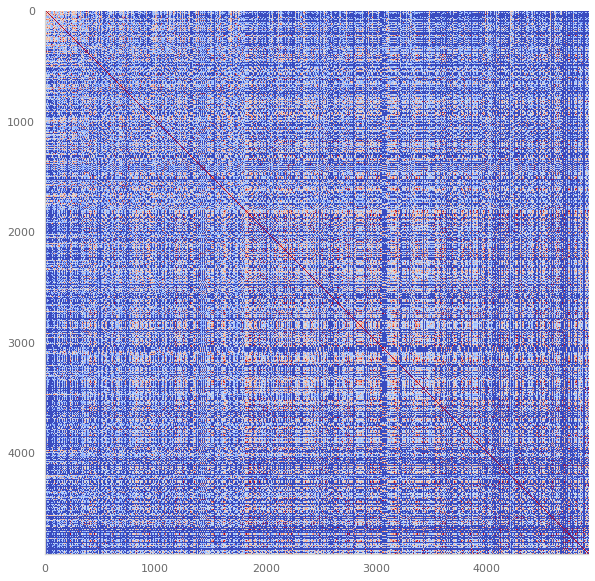

In [8]:
# Heatmap des similarités
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

plt.imshow(mGenres,cmap='coolwarm',interpolation='nearest')

findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.


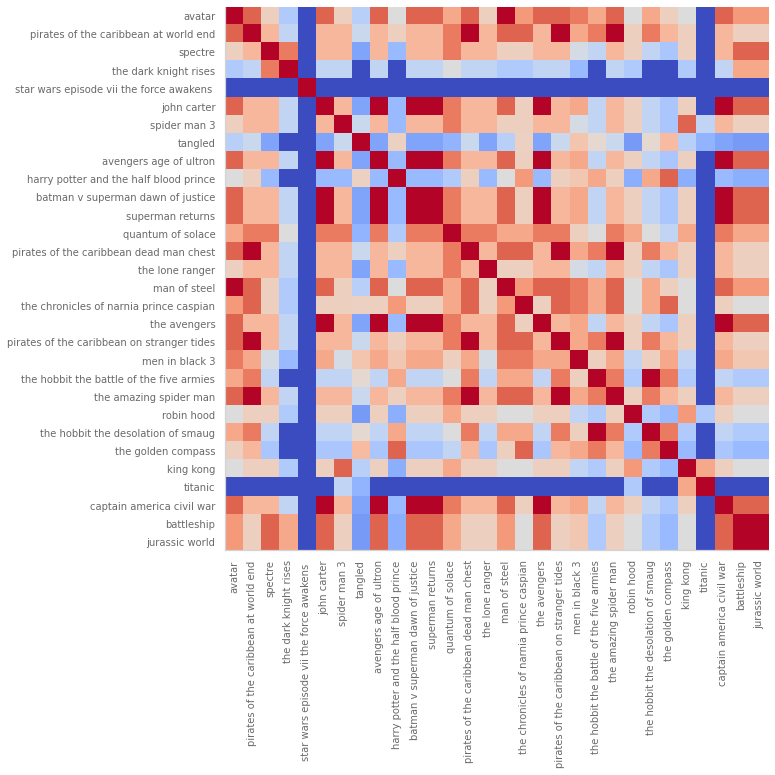

In [9]:
# Zoom Heatmap des similarités

plt.imshow(mGenres[0:30,0:30],cmap='coolwarm',interpolation='nearest');
plt.xticks(range(30), dfMovies['movie_title'][0:30], size='small',rotation='vertical');
plt.yticks(range(30), dfMovies['movie_title'][0:30], size='small');

### <font color=#ffb703>Similarites plots</font>

In [10]:
import numpy as np
from sklearn.decomposition import NMF

# on masque les plots nuls sur toutes les colonnes
mask = (dfPlots == 0).all(axis=1)
del dfPlots['nan']

In [11]:

#X=dfPlots[~mask]
X=dfPlots

pd.set_option('display.max_columns', 30)

nbFacteurs=10

model = NMF(n_components=nbFacteurs, init='random', random_state=0)
W = model.fit_transform(X) # matrice de "weight (poids)" qui determine la contribution des films sur le facteur latent
H = model.components_ # la matrice de contribution du facteur à la variable plot

nX = np.dot(W, H) #on teste la matrice nX, predit par le produit pour verifier si on est proche de la matrice de départ

# la matrice de contribution des facteurs latents à la variable plot
dfH=pd.DataFrame(data=H,    # values
             index=range(nbFacteurs),    #  index
             columns=dfPlots.columns)

dfW=pd.DataFrame(data=W,    # values
             #index=dfMovies[~mask].index, 
             index=dfMovies.index, 
             columns=['friend','police','death','alien','love','revenge','school','high_school','new_york_city','murder'])

Nous pouvons filtrer pour un film, tous les films du même genre

In [12]:
wPlotsLatents=dfW.sort_values(by=['friend','police','death','alien','love','revenge','school','high_school','new_york_city','murder'],ascending=False)
wPlotsLatents

,friend,police,death,alien,love,revenge,school,high_school,new_york_city,murder
4547,4.144649,0.010959,0.011003,0.011153,0.040454,0.109920,0.042224,0.028469,0.032232,0.023202
605,4.041718,0.062454,0.040659,0.021390,0.005698,0.000000,0.000000,0.107095,0.000000,0.000000
3872,4.018098,0.003987,0.003489,0.000000,0.039672,0.085411,0.000000,0.000000,0.035116,0.000000
3463,4.015410,0.000000,0.003249,0.021123,0.023123,0.130274,0.000000,0.000000,0.021815,0.000842
1607,4.010037,0.016562,0.041970,0.015023,0.011437,0.083754,0.023364,0.116465,0.000000,0.025720
...,...,...,...,...,...,...,...,...,...,...
4912,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4913,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4916,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4917,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [13]:
# calcul de similarité entre l'ensemble des 4000 films suivant leurs plots (à partir des facteurs latents)
mPlots=matriceSimilariteCosinus(wPlotsLatents,wPlotsLatents)

<ipython-input-6-bb34b76eb29c>:5: RuntimeWarning: invalid value encountered in true_divide
  return num/(p1*p2)


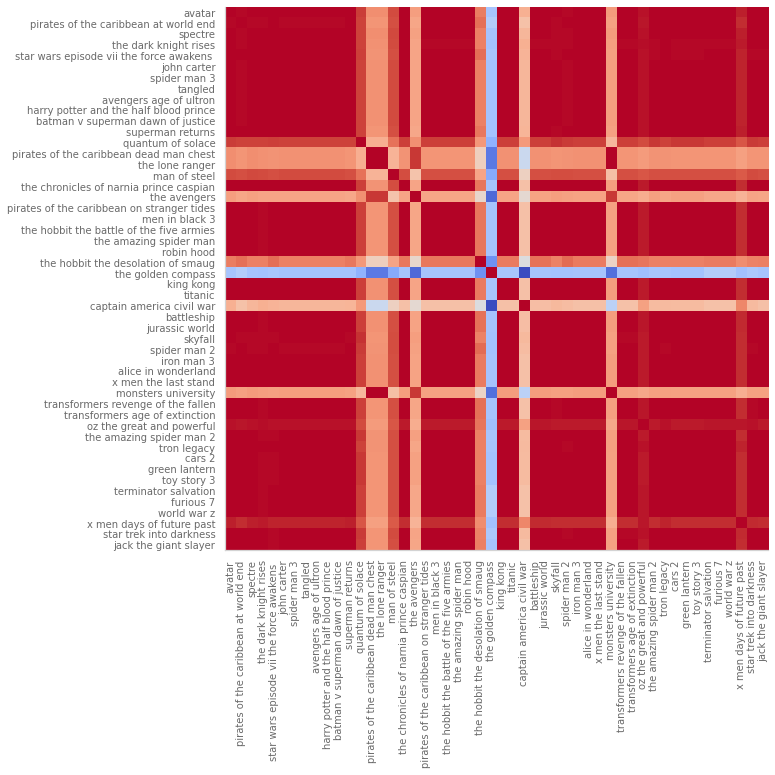

In [14]:
# Zoom Heatmap des similarités

plt.imshow(mPlots[0:50,0:50],cmap='coolwarm',interpolation='nearest');
plt.xticks(range(50), dfMovies['movie_title'][0:50], size='small',rotation='vertical');
plt.yticks(range(50), dfMovies['movie_title'][0:50], size='small');

## <font color=#fb8500>Algorithme de filtrage</font>

En demandant autour de mon entourage, les personnes cherchent généralement les films du même genre et de la même thematique (plots), puis si les acteurs sont connus, c'est du bonus.
De la même maniere nous privilegions donc les fims avec les score de genre et de keywords les plus elevés

In [15]:
# Fonction qui prend le titre du film comme entrée et retourne des films du même genre
def films_genre(titre, simMatrix, df):
    titre=titre.lower()
    # Obtenir l'index du film qui correspond au titre
    indices = (df.stack().reset_index(name="titre")).drop(columns="level_1")
    indices=indices.rename(columns={"level_0": "rownum"})
    # Obtenez les scores de similitude par paires de tous les films avec ce film
    # Et convertissez-le en une liste de tuples comme décrit ci-dessus
    try:
        simScore=simMatrix[indices["titre"]==titre][0]
        resultat=pd.DataFrame({'simScore':simScore,'titre':indices["titre"]}).sort_values('simScore',ascending=False)
        resultat=resultat[resultat['titre']!=titre]
    except IndexError:
        print("titre non trouvé")
        simScore=simMatrix[0]
        resultat=pd.DataFrame(columns = ['simScore','titre'])
    
    return resultat.head(5)

In [16]:
# Fonction qui prend le titre du film comme entrée et retourne des films ayant des plots (intrigues) similaires
def films_plot(titre, simMatrix, df):
    titre=titre.lower()
    # Obtenir l'index du film qui correspond au titre
    indices = (df.stack().reset_index(name="titre")).drop(columns="level_1")
    indices=indices.rename(columns={"level_0": "rownum"})
    # Obtenez les scores de similitude par paires de tous les films avec ce film
    # Et convertissez-le en une liste de tuples comme décrit ci-dessus
    try:
        simScore=simMatrix[indices["titre"]==titre][0]
        resultat=pd.DataFrame({'simScore':simScore,'titre':indices["titre"]}).sort_values('simScore',ascending=False).head(100)
        resultat=resultat[resultat['titre']!=titre]
    except IndexError:
        print("titre non trouvé")
        simScore=simMatrix[0]
        resultat=pd.DataFrame(columns = ['simScore','titre'])
    return resultat.head(5)

In [17]:
import joblib
# dump compressé (bz2) des matrices de similarité plot & genres, et des titres
joblib.dump(mPlots, "mPlots.jbl.bz2")
joblib.dump(mGenres, "mGenres.jbl.bz2")
joblib.dump(dfMovies[["movie_title"]],"dfMoviesTitle.jbl.bz2")

['dfMoviesTitle.jbl.bz2']

In [18]:
titre='ace ventura pet detective'
dfSimGenre=films_genre(titre,mGenres,dfMovies[["movie_title"]])
dfSimGenre

,simScore,titre
2176,1.0,vampires suck
1173,1.0,the big year
2165,1.0,meet the browns
2823,1.0,dick
1726,1.0,the boss


## <font color=#fb8500>Tests</font>

In [19]:
np.info(mPlots)

class:  ndarray
shape:  (4919, 4919)
strides:  (39352, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7ff6b6400000
byteorder:  little
byteswap:  False
type: float64


In [20]:
titre='Figt Club'
dfSimGenre=films_genre(titre,mGenres,dfMovies[["movie_title"]]).head(5)
dfSimPlot=films_plot(titre,mPlots,dfMovies[["movie_title"]]).head(5)

titre non trouvé
titre non trouvé


In [21]:
pd.options.display.min_rows=20
print(dfSimGenre)
print(dfSimPlot)

Empty DataFrame
Columns: [simScore, titre]
Index: []
Empty DataFrame
Columns: [simScore, titre]
Index: []


In [22]:
dfMovies[dfMovies["movie_title"]==titre][["genres","plot_keywords"]]
indexTitre=dfMovies[dfMovies["movie_title"]==titre].index

In [23]:
wPlotsLatents.iloc[indexTitre]

,friend,police,death,alien,love,revenge,school,high_school,new_york_city,murder


In [24]:
dfMovies.iloc[dfSimPlot.index][["movie_title","plot_keywords"]]

,movie_title,plot_keywords


## <font color=#fb8500>Moteur</font>

In [25]:
import joblib
# chargement des matrices de similarité plot & genres, et des titres
mPlots=joblib.load("mPlots.jbl.bz2")
mGenres=joblib.load("mGenres.jbl.bz2")
dfMovieTitle=joblib.load("dfMoviesTitle.jbl.bz2")

In [26]:
#%%writefile engine.py

import pandas as pd 

# Fonction qui prend le titre du film comme entrée et retourne des films du même genre
def films_genre(titre, simMatrix, df):
    titre=titre.lower()
    # Obtenir l'index du film qui correspond au titre
    indices = (df.stack().reset_index(name="titre")).drop(columns="level_1")
    indices=indices.rename(columns={"level_0": "rownum"})
    # Obtenez les scores de similitude par paires de tous les films avec ce film
    # Et convertissez-le en une liste de tuples comme décrit ci-dessus
    try:
        simScore=simMatrix[indices["titre"]==titre][0]
        resultat=pd.DataFrame({'simScore':simScore,'titre':indices["titre"]}).sort_values('simScore',ascending=False)
        resultat=resultat[resultat['titre']!=titre]
    except IndexError:
        print("titre non trouvé")
        simScore=simMatrix[0]
        resultat=pd.DataFrame(columns = ['simScore','titre'])    
    return resultat.head(5)

# Fonction qui prend le titre du film comme entrée et retourne des films ayant des plots (intrigues) similaires
def films_plot(titre, simMatrix, df):
    titre=titre.lower()
    # Obtenir l'index du film qui correspond au titre
    indices = (df.stack().reset_index(name="titre")).drop(columns="level_1")
    indices=indices.rename(columns={"level_0": "rownum"})
    # Obtenez les scores de similitude par paires de tous les films avec ce film
    # Et convertissez-le en une liste de tuples comme décrit ci-dessus
    try:
        simScore=simMatrix[indices["titre"]==titre][0]
        resultat=pd.DataFrame({'simScore':simScore,'titre':indices["titre"]}).sort_values('simScore',ascending=False).head(100)
        resultat=resultat[resultat['titre']!=titre]
    except IndexError:
        print("titre non trouvé")
        simScore=simMatrix[0]
        resultat=pd.DataFrame(columns = ['simScore','titre'])    
    return resultat.head(5)

def get_recommendations(titre, mGenres, mPlots, df):
    dfSimGenre=films_genre(titre,mGenres,df).head(5)
    dfSimPlot=films_plot(titre,mPlots,df).head(5)
    dfConcat=pd.concat([dfSimGenre,dfSimPlot])
    dfTop=dfConcat[dfConcat.duplicated(keep=False)]
    dfBottom=dfConcat.drop_duplicates(subset=['titre'],keep='first', inplace=False)
    dfRecommendations=pd.concat([dfTop,dfBottom])
    return dfRecommendations["titre"].head(10).values.tolist()

In [27]:
#titre='star wars episode ii attack of the clones'
titre='spectre'
get_recommendations(titre,mGenres,mPlots,dfMovieTitle)

['casino royale',
 'dr. no',
 'the bourne legacy',
 'goldfinger',
 'the hunt for red october',
 'john carter',
 'spider man 3',
 'tangled',
 'avengers age of ultron',
 'harry potter and the half blood prince']

In [28]:
now=time.time()
now-start

52.00700306892395